# WeatherPy 

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random
import json 
import requests
import time
import scipy.stats as sts
from scipy import stats
import openweathermapy.core as owm
import csv 

#Import API Key
from config import weather_api_key

# to get the city latitude and longtiude 
from citipy import citipy

# Range of latitudes and longitudes
#https://desktop.arcgis.com/en/arcmap/10.3/guide-books/map-projections/about-geographic-coordinate-systems.htm
lat_range = (-90, 90)
lng_range = (-180, 180)

# Cities Summary 

In [2]:
#Set up lists to hold reponse info for latitude and lontitude
lat_lngs = []
cities = []
countries = []

#Get the random lat and lng then zip together
#https://stackoverflow.com/questions/55230785/how-can-i-generate-a-seed-for-np-random-uniform
lats = np.random.uniform(low=-90.00, high=90.00, size=1500)
lngs = np.random.uniform(low=-180.00, high=180.00, size=1500)
lat_lngs = zip(lats, lngs)


#Get the nearest city based on latitude and lontitude
#https://github.com/wingchen/citipy/blob/master/tests.py
for lat_lng in lat_lngs:
    city = citipy.nearest_city(lat_lng[0], lat_lng[1]).city_name
    country = citipy.nearest_city(lat_lng[0], lat_lng[1]).country_code
    if city not in cities:
        cities.append(city)
        countries.append(country)

#Create DataFrame for city and country         
City_latlong_data = pd.DataFrame({"City": cities, "Country": countries})
City_latlong_data = City_latlong_data.reset_index(drop=True)
City_latlong_data.head() 

#set up additional columns to hold information
City_latlong_data["Cloudiness"] = ""
City_latlong_data["Humidity"] = ""
City_latlong_data["Date"] = ""
City_latlong_data["Max Temp"] = ""
City_latlong_data["Wind Speed"] = ""

#Print the city count
len(cities)

617

In [3]:
#Create a dataframe to store all the latitude and longitude
Cities_df = pd.DataFrame()
Cities_df = Cities_df.append(pd.DataFrame.from_dict({ "Latitude": lats, "Longitude": lngs}))        
Cities_df

#Merge two dataframes to display all the additional columns, drop duplicates and drop nan vaulues
City_Data = [City_latlong_data, Cities_df]        
City_Data_DF = pd.concat([City_latlong_data, Cities_df], axis=1)
City_Data_DF = City_Data_DF.drop_duplicates()
City_Data_DF = City_Data_DF.dropna()
City_Data_DF = City_Data_DF.reset_index(drop=True)
City_Data_DF = pd.DataFrame(City_Data_DF)
City_Data_DF.head(20)

,City,Country,Cloudiness,Humidity,Date,Max Temp,Wind Speed,Latitude,Longitude
0,albany,au,,,,,,-79.408990,114.815037
1,beringovskiy,ru,,,,,,51.709127,178.118981
2,east london,za,,,,,,-63.851721,48.804512
3,barrow,us,,,,,,67.444568,-156.604659
4,kapaa,us,,,,,,18.038161,-166.668122
5,saint-philippe,re,,,,,,-22.422791,57.300919
6,illoqqortoormiut,gl,,,,,,85.819019,-33.239181
7,sao filipe,cv,,,,,,11.911384,-26.638961
8,yenagoa,ng,,,,,,4.695227,6.478253
9,praxedis guerrero,mx,,,,,,31.593843,-105.642517


In [4]:
##* Randomly select **at least** 500 unique (non-repeat) cities based on latitude and longitude.
random_selected_cities = City_Data_DF.sample(500)
#Print the selected cities Dataframe
random_selected_cities = random_selected_cities.reset_index(drop=True)
random_selected_cities = pd.DataFrame(random_selected_cities)
random_selected_cities

,City,Country,Cloudiness,Humidity,Date,Max Temp,Wind Speed,Latitude,Longitude
0,ribeira grande,pt,,,,,,32.247373,-9.241500
1,saquarema,br,,,,,,-9.807679,-157.803819
2,mount gambier,au,,,,,,82.139831,-159.457046
3,fossombrone,it,,,,,,-30.644136,123.656986
4,qaanaaq,gl,,,,,,8.616615,113.678112
...,...,...,...,...,...,...,...,...,...
495,latung,ph,,,,,,33.330877,65.327592
496,ambon,id,,,,,,-5.621360,126.421890
497,chicaman,gt,,,,,,52.307598,-83.949550
498,ozernovskiy,ru,,,,,,5.923029,47.364028


# Get API Calls¶

In [5]:
#https://gt.bootcampcontent.com/GT-Coding-Boot-Camp/gt-atl-data-pt-03-2020-u-c/blob/master/06-Python-APIs/3/Activities/04-Ins_NearestRestr/Solved/NearestRestr.ipynb
#URL for get requests to retrieve weather data - 
url = "http://api.openweathermap.org/data/2.5/weather?units=Imperial&APPID=" + weather_api_key
print(url)
     
# set up lists to hold reponse info
city_name =[]
lat = []
lon = []
temp =[]
temperature_max = []
date = []
humidity = []
wind_speed = []
country = []
cloudiness = []

#counter for data set number of calls
record_count = 1

# Loop through the list of cities and perform a request
#Used Activity 06-Python-APIs/2/Activities/10-Stu_API_Exceptions/Solved/api_exceptions.ipynb
print(f"Generating Data Retrival")

for city in cities:
    
# Try to grab the lists of city responses if availble from json response
    try:
        response = requests.get(f"{url}&q={city}").json()
        #Making sure my url printed 
#        print(response)
        city_name.append(response['name'])
        lat.append(response['coord']['lat'])
        lon.append(response['coord']['lon'])
        temperature_max.append(response['main']['temp_max'])
        date.append(response['dt'])
        humidity.append(response['main']['humidity'])
        wind_speed.append(response['wind']['speed'])
        country.append(response['sys']['country'])
        cloudiness.append(response['clouds']['all'])
        city = response['name']
        print(f"The weather API responded with:# {record_count} | {city}")
        record_count = record_count + 1

        # API CALLS TO SLEEP FOR 1 SECONDS DUE TO FREE 60 CALLS/MIN 
        time.sleep(1)
        
    
    except KeyError: 
        print("City missing...Skipping")
        
print("------------------------")
print("Generated Data Completed")
print("------------------------")

http://api.openweathermap.org/data/2.5/weather?units=Imperial&APPID=9246be5369046e9d6295393ab5911965
Generating Data Retrival
The weather API responded with:# 1 | Albany
The weather API responded with:# 2 | Beringovskiy
The weather API responded with:# 3 | East London
The weather API responded with:# 4 | Barrow
The weather API responded with:# 5 | Kapaa
The weather API responded with:# 6 | Saint-Philippe
City missing...Skipping
The weather API responded with:# 7 | São Filipe
The weather API responded with:# 8 | Yenagoa
The weather API responded with:# 9 | Praxédis Guerrero
The weather API responded with:# 10 | Ribeira Brava
The weather API responded with:# 11 | Punta Arenas
The weather API responded with:# 12 | Swift Current
The weather API responded with:# 13 | Saint-Augustin
The weather API responded with:# 14 | Bredasdorp
The weather API responded with:# 15 | Vaini
The weather API responded with:# 16 | Ambon City
The weather API responded with:# 17 | Klaksvík
The weather API respond

In [6]:
#checking the counts and making sure the information is there needed
# ERROR RECEIVED ABOUT valueerror: arrays must all be same length
print(len(cities), len(country), len(cloudiness), len(humidity), len(date), len(temperature_max),
     len(wind_speed), len(lat), len(lon))

617 564 564 564 564 564 564 564 564


# RAW DATA 

In [7]:
city_weatherpy_dict = {"City": cities, "Country": country, 
                       "Cloudiness %": cloudiness, "Humidity": humidity,
                       "Date": date, "Max Temp (F)": temperature_max,
                       "Wind Speed (mph)": wind_speed, "Latitude": lat,
                       "Longitude": lon
                      }
city_weatherpy_data = pd.DataFrame.from_dict(city_weatherpy_dict, orient='index')
city_weatherpy_data.transpose()

,City,Country,Cloudiness %,Humidity,Date,Max Temp (F),Wind Speed (mph),Latitude,Longitude
0,albany,US,20,51,1587530850,35.6,12.75,42.6,-73.97
1,beringovskiy,RU,5,93,1587530950,13.59,8.84,63.05,179.32
2,east london,ZA,75,93,1587530951,60.8,13.87,-33.02,27.91
3,barrow,US,90,85,1587530701,14,13.87,71.29,-156.79
4,kapaa,US,75,83,1587530953,75.2,8.05,22.08,-159.32
...,...,...,...,...,...,...,...,...,...
612,atbasar,None,None,None,None,None,None,None,None
613,roswell,None,None,None,None,None,None,None,None
614,harper,None,None,None,None,None,None,None,None
615,thinadhoo,None,None,None,None,None,None,None,None


In [8]:
# When I printed my code the columns were labeled as the rows vice versa so I found I needed to use T to transpose the data back. It fixed the issue and I was also able to print the csv file correctly as well. 
transposed_data = city_weatherpy_data.T
transposed_data

,City,Country,Cloudiness %,Humidity,Date,Max Temp (F),Wind Speed (mph),Latitude,Longitude
0,albany,US,20,51,1587530850,35.6,12.75,42.6,-73.97
1,beringovskiy,RU,5,93,1587530950,13.59,8.84,63.05,179.32
2,east london,ZA,75,93,1587530951,60.8,13.87,-33.02,27.91
3,barrow,US,90,85,1587530701,14,13.87,71.29,-156.79
4,kapaa,US,75,83,1587530953,75.2,8.05,22.08,-159.32
...,...,...,...,...,...,...,...,...,...
612,atbasar,None,None,None,None,None,None,None,None
613,roswell,None,None,None,None,None,None,None,None
614,harper,None,None,None,None,None,None,None,None
615,thinadhoo,None,None,None,None,None,None,None,None


In [9]:
#Droping the empty rows that are listed as none above which leaves me with 577 cities
transposed_data.dropna(inplace=True)
transposed_data

,City,Country,Cloudiness %,Humidity,Date,Max Temp (F),Wind Speed (mph),Latitude,Longitude
0,albany,US,20,51,1587530850,35.6,12.75,42.6,-73.97
1,beringovskiy,RU,5,93,1587530950,13.59,8.84,63.05,179.32
2,east london,ZA,75,93,1587530951,60.8,13.87,-33.02,27.91
3,barrow,US,90,85,1587530701,14,13.87,71.29,-156.79
4,kapaa,US,75,83,1587530953,75.2,8.05,22.08,-159.32
...,...,...,...,...,...,...,...,...,...
559,skalistyy,KZ,0,21,1587531619,75.76,18.57,51.8,68.33
560,ixtapa,US,1,51,1587531620,59,8.03,34.02,-84.36
561,aykhal,LR,54,85,1587531621,79.86,7.4,4.38,-7.72
562,ambodifototra,MV,100,88,1587531622,77.5,3.74,0.53,72.93


In [10]:
#Output for my csv file
transposed_data.to_csv("./output_data/what_weatherpy_data.csv") 

In [28]:
#Read my Output file to make sure data is formatted correctly for my csv file
transposed_data = pd.read_csv("./output_data/what_weatherpy_data.csv")
transposed_data.head()

,Unnamed: 0,City,Country,Cloudiness %,Humidity,Date,Max Temp (F),Wind Speed (mph),Latitude,Longitude
0,0,albany,US,20,51,1587530850,35.60,12.75,42.60,-73.97
1,1,beringovskiy,RU,5,93,1587530950,13.59,8.84,63.05,179.32
2,2,east london,ZA,75,93,1587530951,60.80,13.87,-33.02,27.91
3,3,barrow,US,90,85,1587530701,14.00,13.87,71.29,-156.79
4,4,kapaa,US,75,83,1587530953,75.20,8.05,22.08,-159.32


# Plotting the Data - Latitude VS Temperature (F) plot 
    * Save a CSV of all retrieved data and a PNG image for each scatter plot.
    * You must use proper labeling of your plots, including aspects like: Plot Titles (with date of analysis) and Axes Labels.
    * For max intensity in the heat map, try setting it to the highest humidity found in the data set.

In [12]:
from datetime import datetime
date_stamp = datetime.date(datetime.now())
print(date_stamp)

2020-04-22


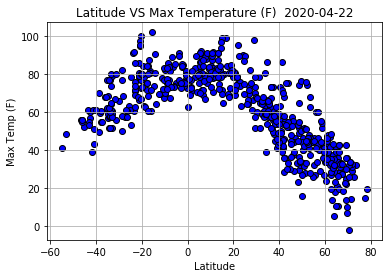

<Figure size 432x288 with 0 Axes>

In [13]:
#Plotting the Data - Latitude VS Temperature (F) plot 
x_values = transposed_data['Latitude']
y_values = transposed_data['Max Temp (F)']
plt.scatter(x_values, y_values, c="blue", edgecolors="black")

plt.xlabel('Latitude')
plt.ylabel('Max Temp (F)')
plt.title(f"Latitude VS Max Temperature (F)  {date_stamp}")
plt.grid()
plt.show()
plt.savefig("./output_data/Latitude_VS_Temperature.png")

#After each plot add a sentence or too explaining what the code is and analyzing.


*The scatter above is showing the relationship between latitude vs max temperature. As the city position is closer to the latitude of the Equator which is 0 the temps are above 70 degrees or more. If the latitude if farther away from the Equator the tempertature will decrease. 

# Humidity (%) vs. Latitude

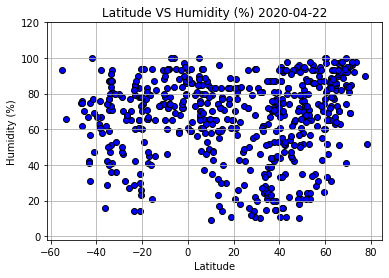

In [14]:
#Create a scatter plot for Humidity (%) vs. Latitude
x_values = transposed_data['Latitude']
y_values = transposed_data['Humidity']
plt.scatter(x_values, y_values, c="blue", edgecolors="black")
plt.grid()
plt.xlabel('Latitude')
plt.ylabel('Humidity (%)')
plt.ylim(-2, 120)
plt.title(f"Latitude VS Humidity (%) {date_stamp}")
plt.savefig("./output_data/Latitude_VS_Humidity.png")
plt.show()

#After each plot add a sentence or too explaining what the code is and analyzing.
    After looking at the scatter plot it looks like there are a several cities with high humidity % around 70% to 100% near the Equator and also between 60Lat to 80Lat shows a significant number of high humidity above 80%.

# Cloudiness (%) vs. Latitude

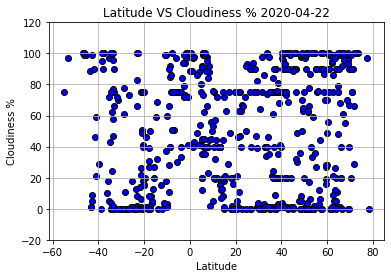

In [15]:
#Create a scatter plot for Cloudiness (%) vs. Latitude
x_values = transposed_data['Latitude']
y_values = transposed_data['Cloudiness %']
plt.scatter(x_values, y_values, c="blue", edgecolors="black")
plt.grid()
plt.xlabel('Latitude')
plt.ylabel('Cloudiness %')
plt.ylim(-20, 120)
plt.title(f"Latitude VS Cloudiness % {date_stamp}")
plt.savefig("./output_data/Latitude_VS_Cloudiness.png")
plt.show()

There doesn't seem to be any relationship between the cloudiness and the position of the cities. 

# Wind Speed (mph) vs. Latitude

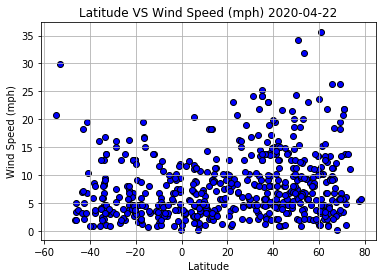

In [16]:
#Create a scatter plot for Wind Speed (mph) vs. Latitude
x_values = transposed_data['Latitude']
y_values = transposed_data['Wind Speed (mph)']
plt.scatter(x_values, y_values, c="blue", edgecolors="black")
plt.grid()
plt.xlabel('Latitude')
plt.ylabel('Wind Speed (mph)')
plt.title(f"Latitude VS Wind Speed (mph) {date_stamp}")
plt.savefig("./output_data/Latitude_VS_WindSpeed.png")
plt.show()

There doesn't seem to be a difference in the wind speed and the position of the cities. There are multiple cities with a wind speed of 0 to 5 between the latitude of -40 to 70 in the southern area. But there are very minimial windspeeds in the northern part of the graph. 

# Create a linear regression plot & Create the DataFrames for the hemispheres 

#Your second requirement is to run linear regression on each relationship, only this time separating them into Northern Hemisphere (greater than or equal to 0 degrees latitude) and Southern Hemisphere (less than 0 degrees latitude):

* Northern Hemisphere - Temperature (F) vs. Latitude
* Southern Hemisphere - Temperature (F) vs. Latitude
* Northern Hemisphere - Humidity (%) vs. Latitude
* Southern Hemisphere - Humidity (%) vs. Latitude
* Northern Hemisphere - Cloudiness (%) vs. Latitude
* Southern Hemisphere - Cloudiness (%) vs. Latitude
* Northern Hemisphere - Wind Speed (mph) vs. Latitude
* Southern Hemisphere - Wind Speed (mph) vs. Latitude

In [17]:
#Northern Hemipshere is everything above the Equator >= 0
#Southern Hemipshere is everything below the Equator < 0
North_Hem_df = transposed_data[transposed_data["Latitude"]>= 0]
South_Hem_df = transposed_data[transposed_data["Latitude"]< 0]

# Northern Hemisphere - Temperature (F) vs. Latitude

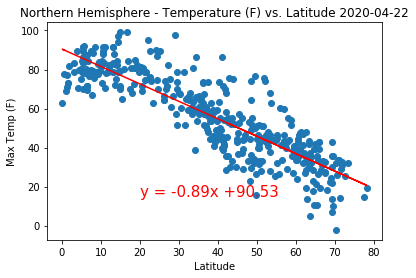

The r-squared is: 0.7453415920516072


<Figure size 432x288 with 0 Axes>

In [18]:
from matplotlib import pyplot as plt
from scipy.stats import linregress

# Create a Scatter Plot for temperature vs latitude
x_values = North_Hem_df['Latitude']
y_values = North_Hem_df['Max Temp (F)']

 # Perform a linear regression on temperature vs. latitude
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)

# Get regression values
regress_values = x_values * slope + intercept

# Create line equation string
line_eq = "y = " + str(round(slope,2)) + "x +" + str(round(intercept,2))

# Create Plot
plt.scatter(x_values,y_values)
plt.plot(x_values,regress_values,"r-")

# Label plot and annotate the line equation
plt.xlabel('Latitude')
plt.ylabel('Max Temp (F)')
plt.title(f"Northern Hemisphere - Temperature (F) vs. Latitude {date_stamp}")
plt.annotate(line_eq,(20,15),fontsize=15,color="red")
plt.show()      
plt.savefig("./output_data/NorthernHemisphereTemperatureVSLatitude.png")

# Print r square value
print(f"The r-squared is: {rvalue**2}")

# Southern Hemisphere - Temperature (F) vs. Latitude

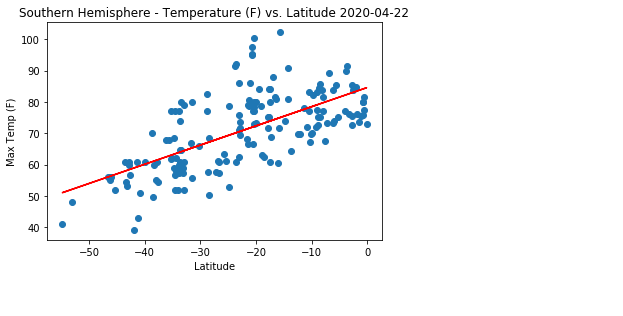

The r-squared is: 0.436735235999278


<Figure size 432x288 with 0 Axes>

In [19]:
from matplotlib import pyplot as plt
from scipy.stats import linregress

x_values = South_Hem_df['Latitude']
y_values = South_Hem_df['Max Temp (F)']
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.scatter(x_values,y_values)
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(20,15),fontsize=15,color="red")
plt.xlabel('Latitude')
plt.ylabel('Max Temp (F)')
plt.title(f"Southern Hemisphere - Temperature (F) vs. Latitude {date_stamp}")

plt.show()
# Print r square value
print(f"The r-squared is: {rvalue**2}")

plt.savefig("./output_data/SouthernHemisphereTemperatureVSLatitude.png")

# Northern Hemisphere - Humidity (%) vs. Latitude

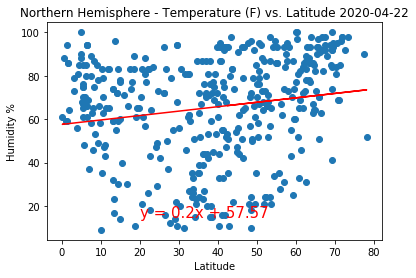

The r-squared is: 0.030903620654253807


<Figure size 432x288 with 0 Axes>

In [20]:
from matplotlib import pyplot as plt
from scipy.stats import linregress

x_values = North_Hem_df['Latitude']
y_values = North_Hem_df['Humidity']
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.scatter(x_values,y_values)
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(20,15),fontsize=15,color="red")
plt.xlabel('Latitude')
plt.ylabel('Humidity %')
plt.title(f"Northern Hemisphere - Temperature (F) vs. Latitude {date_stamp}")
plt.show()

# Print r square value
print(f"The r-squared is: {rvalue**2}")
plt.savefig("./output_data/NorthernHemisphereHumidityVSLatitude.png")
plt.show()

# Southern Hemisphere - Humidity (%) vs. Latitude

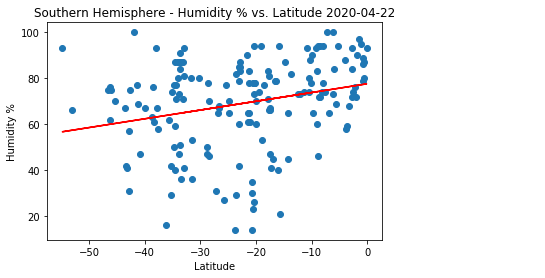

The r-squared is: 0.0655116827764944


<Figure size 432x288 with 0 Axes>

In [21]:
from matplotlib import pyplot as plt
from scipy.stats import linregress

x_values = South_Hem_df["Latitude"]
y_values = South_Hem_df["Humidity"]
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.scatter(x_values,y_values)
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(6,10),fontsize=15,color="red")
plt.xlabel('Latitude')
plt.ylabel('Humidity %')
plt.title(f"Southern Hemisphere - Humidity % vs. Latitude {date_stamp}")
plt.show()
# Print r square value
print(f"The r-squared is: {rvalue**2}")

plt.savefig("./output_data/SouthernHemisphereHumidityVSLatitude.png")

# Northern Hemisphere - Cloudiness (%) vs. Latitude

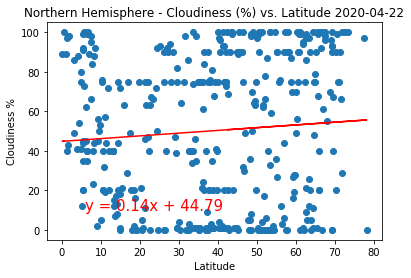

The r-squared is: 0.005920442796704577


<Figure size 432x288 with 0 Axes>

In [22]:
from matplotlib import pyplot as plt
from scipy.stats import linregress

x_values = North_Hem_df["Latitude"]
y_values = North_Hem_df["Cloudiness %"]
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.scatter(x_values,y_values)
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(6,10),fontsize=15,color="red")
plt.xlabel('Latitude')
plt.ylabel('Cloudiness %')
plt.title(f"Northern Hemisphere - Cloudiness (%) vs. Latitude {date_stamp}")
plt.show()
# Print r square value
print(f"The r-squared is: {rvalue**2}")

plt.savefig("./output_data/NorthernHemisphereCloudinessVSLatitude.png")
plt.show()

# Southern Hemisphere - Cloudiness (%) vs. Latitude

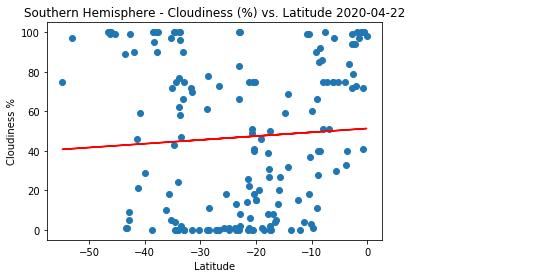

The r-squared is: 0.004455218719629298


<Figure size 432x288 with 0 Axes>

In [23]:
from matplotlib import pyplot as plt
from scipy.stats import linregress

x_values = South_Hem_df["Latitude"]
y_values = South_Hem_df["Cloudiness %"]
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.scatter(x_values,y_values)
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(6,10),fontsize=15,color="red")
plt.xlabel('Latitude')
plt.ylabel('Cloudiness %')
plt.title(f"Southern Hemisphere - Cloudiness (%) vs. Latitude {date_stamp}")
plt.show()
# Print r square value
print(f"The r-squared is: {rvalue**2}")

plt.savefig("./output_data/SouthernHemisphereCloudinessVSLatitude.png")
plt.show()

# Northern Hemisphere - Wind Speed (mph) vs. Latitude

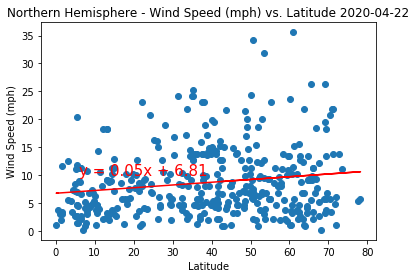

The r-squared is: 0.027766064382221053


<Figure size 432x288 with 0 Axes>

In [25]:
from matplotlib import pyplot as plt
from scipy.stats import linregress

x_values = North_Hem_df["Latitude"]
y_values = North_Hem_df["Wind Speed (mph)"]
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.scatter(x_values,y_values)
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(6,10),fontsize=15,color="red")
plt.xlabel('Latitude')
plt.ylabel('Wind Speed (mph)')
plt.title(f"Northern Hemisphere - Wind Speed (mph) vs. Latitude {date_stamp}")
plt.show()
# Print r square value
print(f"The r-squared is: {rvalue**2}")


plt.savefig("./output_data/NorthernHemisphereWindSpeedVSLatitude.png")
plt.show()

# Southern Hemisphere - Wind Speed (mph) vs. Latitude

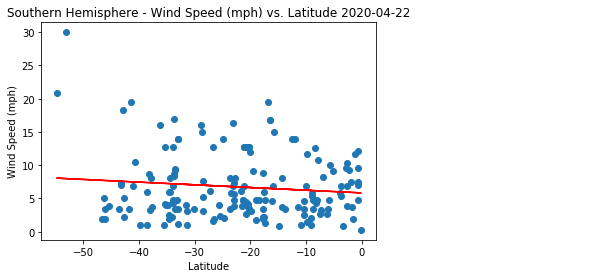

The r-squared is: 0.011828989668180816


<Figure size 432x288 with 0 Axes>

In [26]:
from matplotlib import pyplot as plt
from scipy.stats import linregress

# Create a Scatter Plot for temperature vs latitude
x_values = South_Hem_df['Latitude']
y_values = South_Hem_df['Wind Speed (mph)']

 # Perform a linear regression on temperature vs. latitude
(slope, intercept, rvalue, pvalue, stderr) = stats.linregress(x_values, y_values)

# Get regression values
regress_values = x_values * slope + intercept
# Create line equation string
line_eq = "y = " + str(round(slope,2)) + "x +" + str(round(intercept,2))

# Create Plot
plt.scatter(x_values,y_values)
plt.plot(x_values,regress_values,"r-")

# Label plot and annotate the line equation
plt.xlabel('Latitude')
plt.ylabel('Wind Speed (mph)')
plt.annotate(line_eq,(20,15),fontsize=15,color="red")
plt.title(f"Southern Hemisphere - Wind Speed (mph) vs. Latitude {date_stamp}")
plt.show()
# Print r square value
print(f"The r-squared is: {rvalue**2}")

plt.savefig("./output_data/SouthernHemisphereWindSpeedVSLatitude.png")